Perovskite modelling program - returning PSC stack from an input row (from perovskite database)

### Data Preprocessing 
1. Initital cleaning of ions and coefficients
2. Include 'combined' ions, coefficients and sites columns for vector embedding

In [124]:

import pandas as pd
import re

# Load the CSV file
file_path = r"C:\Users\c\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Data\Perovsite database query.csv"
data = pd.read_csv(file_path)

# Define the columns to keep
columns_to_keep = [
    'Cell_stack_sequence', 'Cell_architecture',
    'Substrate_stack_sequence', 'Substrate_thickness',
    'ETL_stack_sequence', 'ETL_thickness', 'ETL_additives_compounds', 'ETL_additives_concentrations',
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients', 
    'Perovskite_additives_compounds', 'Perovskite_additives_concentrations', 'Perovskite_thickness',
    'HTL_stack_sequence', 'HTL_thickness_list', 'HTL_additives_compounds', 'HTL_additives_concentrations',
    'Backcontact_stack_sequence', 'Backcontact_thickness', 
    'Backcontact_additives_compounds', 'Backcontact_additives_concentrations',
    'Add_lay_front', 'Add_lay_front_function', 'Add_lay_front_stack_sequence', 'Add_lay_front_thickness_list', 
    'Add_lay_front_additives_compounds', 'Add_lay_front_additives_concentrations',
    'Add_lay_back', 'Add_lay_back_function', 'Add_lay_back_stack_sequence', 'Add_lay_back_thickness_list', 
    'Add_lay_back_additives_compounds', 'Add_lay_back_additives_concentrations',
    'Encapsulation', 'Encapsulation_stack_sequence', 'JV_default_PCE', 'Perovskite_band_gap'
    ]

# Filter columns to keep only those that exist in the dataset
existing_columns = [col for col in columns_to_keep if col in data.columns]
data = data[existing_columns]

data.columns = data.columns.str.strip()

# # Add an index column
# data.reset_index(inplace=True)
# data.rename(columns={'index': 'Index'}, inplace=True)

# # Save the filtered dataset to a new CSV file
# output_path = 'filtered_DatabaseMaterials_with_index.csv'
# data.to_csv(output_path, index=False)
# print("Filtered dataset with index saved as", output_path)

# Create a dataframe for ions and their coefficients
ion_columns = [
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients'
]

ion_data = data[ion_columns]

# # Save the unchanged ion data
# output_path = 'ion_data_unchanged.csv'
# ion_data.to_csv(output_path, index=False)
# print("Unchanged ion data saved as", output_path)

import re

# Function to clean and normalize molecule names
def clean_molecule_name(name):
    # Remove leading/trailing spaces and normalize space
    name = name.strip()
    
    # Remove brackets (parentheses, square, and curly brackets)
    name = re.sub(r'[\[\]{}()]', '', name)

    # Allow alphanumeric characters and hyphens; preserve molecule names
    name = re.sub(r'[^a-zA-Z0-9\s\-]+', ' ', name)

    # Replace multiple spaces with a single space and trim again
    name = re.sub(r'\s+', ' ', name).strip()
    
    # Split the string into individual molecule components based on spaces
    elements = name.split()

    # Include valid molecule names, excluding numeric-only components
    elements = [element for element in elements if element and 
                not element.replace('.', '', 1).isdigit()]

    return elements


# Function to clean and convert coefficients to floats
def clean_and_convert_coefficient(coefficient):
    try:
        # Remove non-numeric characters except periods and minus signs
        cleaned_coefficient = re.sub(r'[^0-9.-]', '', coefficient)
        return float(cleaned_coefficient)
    except ValueError:
        return 0.0  # Default to 0.0 if conversion fails
    
# Function to split ions and coefficients into dictionaries
def extract_ions_and_coefficients(ions_column, coefficients_column):
    # Split ions and coefficients by ';' and '|'
    ions = re.split(r'[;|]', ions_column)
    coefficients = re.split(r'[;|]', coefficients_column)
    
    # Clean and convert to floats
    coefficients = [clean_and_convert_coefficient(c) for c in coefficients]
    
    # Clean ion names and split into individual elements
    all_ions = []
    for ion in ions:
        cleaned_ions = clean_molecule_name(ion)  # Clean and split the ion names
        all_ions.extend(cleaned_ions)            # Add each individual element
    
    return all_ions, coefficients

# Function to normalize coefficients
def normalize_coefficients(cell):
    if pd.notna(cell):
        try:
            coefficients = [float(x.strip()) for x in re.split(r'[;|]', cell) if x.strip()]
            total_sum = sum(coefficients)
            return ';'.join(f"{val / total_sum:.3f}" for val in coefficients) if total_sum > 0 else cell
        except ValueError:
            return cell
    return cell

# Normalize coefficients in each column
coefficient_columns = [
    'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions_coefficients', 
    'Perovskite_composition_c_ions_coefficients'
]

for col in coefficient_columns:
    data[col] = data[col].apply(normalize_coefficients)

# Create a set of unique molecules and add new columns
unique_molecules = set()
for column_group in ['a', 'b', 'c']:
    ions_column = f'Perovskite_composition_{column_group}_ions'
    coefficients_column = f'Perovskite_composition_{column_group}_ions_coefficients'
    for _, row in data.iterrows():
        ions, _ = clean_molecule_name(str(row[ions_column])), [clean_and_convert_coefficient(c) for c in str(row[coefficients_column]).split(';')]
        unique_molecules.update(ions)

# Create columns for each unique molecule and calculate proportions
for molecule in unique_molecules:
    data[molecule] = 0.0

for index, row in data[coefficient_columns].iterrows():
    for column_group in ['a', 'b', 'c']:
        ions_column = f'Perovskite_composition_{column_group}_ions'
        coefficients_column = f'Perovskite_composition_{column_group}_ions_coefficients'
        ions = clean_molecule_name(str(row.get(ions_column, "")))
        coefficients = [clean_and_convert_coefficient(c) for c in str(row[coefficients_column]).split(';')]
        total_coeff = sum(coefficients) if sum(coefficients) != 0 else 1
        
        for ion, coeff in zip(ions, coefficients):
            data.at[index, ion] += coeff / total_coeff


# Create a new column 'Layer_Type' to indicate if the row is multilayered or single-layered

data['Layer Type'] = data.apply(
    lambda row: 'Multi-layered Perovskite' if any('|' in str(row[col]) for col in ion_columns) else 'Single-layered Perovskite',
    axis=1
)

# Add/append columns for 'combined ions' and 'combined coefficients' - vector embedding

data['combined_ions'] = data.apply(
    lambda row: f"{row.get('Perovskite_composition_a_ions', '')},{row.get('Perovskite_composition_b_ions', '')},{row.get('Perovskite_composition_c_ions', '')}", 
    axis=1
)

data['combined_coefficients'] = data.apply(
    lambda row: f"{row.get('Perovskite_composition_a_ions_coefficients', '')},{row.get('Perovskite_composition_b_ions_coefficients', '')},{row.get('Perovskite_composition_c_ions_coefficients', '')}", 
    axis=1
)

# ### make sure all combined ions and combined coefficients are lists

import re

# Function to convert a string with mixed delimiters to a list
def convert_to_list(entry):
    if isinstance(entry, str):
        # Replace semicolons and pipes with commas for uniformity
        entry = re.sub(r'[;|]', ',', entry)
        # Split the string by commas and strip spaces around each item
        return [item.strip() for item in entry.split(',') if item.strip()]
    elif isinstance(entry, list):
        return entry  # Already a list, no action needed
    else:
        return []  # Handle missing or invalid entries

# Function to convert string entries to float and handle non-numeric values
def safe_convert_to_float(entry):
    try:
        return float(entry)  # Attempt to convert to float
    except ValueError:
        return None  # If conversion fails, return None (or handle as needed)


### add an indication of perovskite site

# Add the 'combined_sites' column
def generate_combined_sites(row):
    # Split combined ions and coefficients into lists
    ions = row['combined_ions']
    coefficients = row['combined_coefficients']
    
    # Assign sites ('a', 'b', 'c') based on the origin of each ion/coefficient
    sites = []
    site_labels = ['a', 'b', 'c']
    for site, ions_col, coeff_col in zip(site_labels, 
                                         ['Perovskite_composition_a_ions', 'Perovskite_composition_b_ions', 'Perovskite_composition_c_ions'], 
                                         ['Perovskite_composition_a_ions_coefficients', 'Perovskite_composition_b_ions_coefficients', 'Perovskite_composition_c_ions_coefficients']):
        # Count the number of ions and coefficients from this site
        num_ions = len(clean_molecule_name(str(row.get(ions_col, ""))))
        num_coefficients = len(str(row.get(coeff_col, "")).split(';'))
        
        # Append the site label for each ion/coefficient from this site
        sites.extend([site] * max(num_ions, num_coefficients))
    
    return sites

# Apply the function to generate the 'combined_sites' column
data['combined_sites'] = data.apply(generate_combined_sites, axis=1)

def clean_coefficients(coefficients):
    """
    Cleans the coefficients by ensuring all values are numeric.
    Invalid or non-numeric values are replaced with 0.0.
    If the value is already a float, it is left unchanged.
    """
    cleaned = []
    for c in coefficients:
        if isinstance(c, float):  # If already a float, keep it as is
            cleaned.append(c)
        elif isinstance(c, str) and c.replace('.', '', 1).isdigit():  # If a valid string representation of a number
            cleaned.append(float(c))
        else:  # For invalid entries
            cleaned.append(0.0)
    return cleaned

def normalize_coefficients_within_cell(row):
    """
    Normalizes the coefficients for each site ('a', 'b', 'c') within a cell.
    Ensures that the sum of coefficients for each site equals 1.
    """
    # Extract ions, coefficients, and sites for the row
    ions = row['combined_ions']
    coefficients = row['combined_coefficients']
    sites = row['combined_sites']
    
    # Initialize lists for each site
    site_a_coeffs = []
    site_b_coeffs = []
    site_c_coeffs = []
    
    # Separate the coefficients by their sites
    for coeff, site in zip(coefficients, sites):
        try:
            coeff = float(coeff)  # Ensure coefficients are numeric
        except ValueError:
            coeff = 0.0  # Default to 0.0 if invalid
        if site == 'a':
            site_a_coeffs.append(coeff)
        elif site == 'b':
            site_b_coeffs.append(coeff)
        elif site == 'c':
            site_c_coeffs.append(coeff)
    
    # Normalize the coefficients for each site if their sum is not zero
    def normalize(site_coeffs):
        total = sum(site_coeffs)
        return [coeff / total for coeff in site_coeffs] if total > 0 else site_coeffs
    
    site_a_coeffs = normalize(site_a_coeffs)
    site_b_coeffs = normalize(site_b_coeffs)
    site_c_coeffs = normalize(site_c_coeffs)
    
    # Combine all coefficients back into a single list
    normalized_coeffs = site_a_coeffs + site_b_coeffs + site_c_coeffs

    return normalized_coeffs

# Apply the function to both columns
data['combined_ions'] = data['combined_ions'].apply(convert_to_list)
data['combined_coefficients'] = data['combined_coefficients'].apply(
    lambda x: [safe_convert_to_float(item) for item in convert_to_list(x)]  # Convert to float for coefficients, handle errors
)

# Step 1: Clean the coefficients column
data['combined_coefficients'] = data['combined_coefficients'].apply(clean_coefficients)


# Step 2: Normalize coefficients within each cell
data['combined_coefficients'] = data.apply(normalize_coefficients_within_cell, axis=1)
data['combined_coefficients'] = data['combined_coefficients'].apply(
    lambda x: [float(coeff) if str(coeff).replace('.', '', 1).isdigit() else 0.0 for coeff in x] if isinstance(x, list) else []
)

# Verify the transformation
print(data[['combined_ions', 'combined_coefficients', 'combined_sites']].head())


# Drop the original ion columns
data = data.drop(columns=ion_columns, errors='ignore')

# Save the modified DataFrame with the 'Layer Type' and combined columns
output_file_path = 'data_with_layer_type_and_combined.csv'
data.to_csv(output_file_path, index=False)
print("CSV file with layer type information modified and saved as:", output_file_path)


C:\Users\c\AppData\Local\Temp\ipykernel_25628\544507222.py:6: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
C:\Users\c\AppData\Local\Temp\ipykernel_25628\544507222.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[molecule] = 0.0
C:\Users\c\AppData\Local\Temp\ipykernel_25628\544507222.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

     combined_ions combined_coefficients combined_sites
0      [Cs, Sn, I]       [1.0, 1.0, 1.0]      [a, b, c]
1  [Cs, Sn, Br, I]  [1.0, 1.0, 0.1, 0.9]   [a, b, c, c]
2  [Cs, Sn, Br, I]  [1.0, 1.0, 0.5, 0.5]   [a, b, c, c]
3  [Cs, Sn, Br, I]  [1.0, 1.0, 0.9, 0.1]   [a, b, c, c]
4     [Cs, Sn, Br]       [1.0, 1.0, 1.0]      [a, b, c]
CSV file with layer type information modified and saved as: data_with_layer_type_and_combined.csv


In [133]:

import pandas as pd
import re
# Load the CSV file
file_path = r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Data\Perovsite database query.csv'  # Change this to your actual file path
data = pd.read_csv(file_path)


# Define the columns to keep
columns_to_keep = [
    'Cell_stack_sequence', 'Cell_architecture',
    'Substrate_stack_sequence', 'Substrate_thickness',
    'ETL_stack_sequence', 'ETL_thickness', 'ETL_additives_compounds', 'ETL_additives_concentrations',
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients', 
    'Perovskite_additives_compounds', 'Perovskite_additives_concentrations', 'Perovskite_thickness',
    'HTL_stack_sequence', 'HTL_thickness_list', 'HTL_additives_compounds', 'HTL_additives_concentrations',
    'Backcontact_stack_sequence', 'Backcontact_thickness', 
    'Backcontact_additives_compounds', 'Backcontact_additives_concentrations',
    'Add_lay_front', 'Add_lay_front_function', 'Add_lay_front_stack_sequence', 'Add_lay_front_thickness_list', 
    'Add_lay_front_additives_compounds', 'Add_lay_front_additives_concentrations',
    'Add_lay_back', 'Add_lay_back_function', 'Add_lay_back_stack_sequence', 'Add_lay_back_thickness_list', 
    'Add_lay_back_additives_compounds', 'Add_lay_back_additives_concentrations',
    'Encapsulation', 'Encapsulation_stack_sequence', 'JV_default_PCE'
    ]

# Filter columns to keep only those that exist in the dataset
existing_columns = [col for col in columns_to_keep if col in data.columns]
data_cleaned = data[existing_columns]

data.columns = data.columns.str.strip()

# Drop rows with NaN values in important columns
data_cleaned.dropna(subset=[
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients',
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients'
], inplace=True)

# # Remove rows where 'Perovskite_band_gap' contains '|'
# data_cleaned = data_cleaned[~data_cleaned['Perovskite_band_gap'].str.contains('|', na=False)]

# Reset index after dropping rows
data_cleaned.reset_index(drop=True, inplace=True)

import re

# Function to clean and normalize molecule names
def clean_molecule_name(name):
    # Remove leading/trailing spaces and normalize space
    name = name.strip()
    
    # Remove brackets (parentheses, square, and curly brackets)
    name = re.sub(r'[\[\]{}()]', '', name)

    # Allow alphanumeric characters and hyphens; preserve molecule names
    name = re.sub(r'[^a-zA-Z0-9\s\-]+', ' ', name)

    # Replace multiple spaces with a single space and trim again
    name = re.sub(r'\s+', ' ', name).strip()
    
    # Split the string into individual molecule components based on spaces
    elements = name.split()

    # Include valid molecule names, excluding numeric-only components
    elements = [element for element in elements if element and 
                not element.replace('.', '', 1).isdigit()]

    return elements



# Function to clean and convert coefficients to floats
def clean_and_convert_coefficient(coefficient):
    try:
        # Remove non-numeric characters except periods and minus signs
        cleaned_coefficient = re.sub(r'[^0-9.-]', '', coefficient)
        return float(cleaned_coefficient)
    except ValueError:
        return 0.0  # Default to 0.0 if conversion fails

# Function to split ions and coefficients into dictionaries
def extract_ions_and_coefficients(ions_column, coefficients_column):
    # Split ions and coefficients by ';' and '|'
    ions = re.split(r'[;|]', ions_column)
    coefficients = re.split(r'[;|]', coefficients_column)
    
    # Clean and convert to floats
    coefficients = [clean_and_convert_coefficient(c) for c in coefficients]
    
    # Clean ion names and split into individual elements
    all_ions = []
    for ion in ions:
        cleaned_ions = clean_molecule_name(ion)  # Clean and split the ion names
        all_ions.extend(cleaned_ions)            # Add each individual element
    
    return all_ions, coefficients

# Step 1: Identify unique molecules
unique_molecules = set()

# Go through each row to identify unique ions
for index, row in data_cleaned.iterrows():
    for column_group in ['a', 'b', 'c']:
        ions_column = f'Perovskite_composition_{column_group}_ions'
        coefficients_column = f'Perovskite_composition_{column_group}_ions_coefficients'
        
        ions = str(row[ions_column]).split(';')
        all_ions = []
        for ion in ions:
            cleaned_ions = clean_molecule_name(ion)
            all_ions.extend(cleaned_ions)
        unique_molecules.update(all_ions)

# Remove any 'nan' from unique molecules set
unique_molecules.discard('nan')

# Step 2: Create new columns for each unique molecule
for molecule in unique_molecules:
    data_cleaned[molecule] = 0.0  # Initialize columns for each molecule with 0.0

# Step 3: Calculate the proportions for each molecule
for index, row in data_cleaned.iterrows():
    # Iterate over the ion columns and their coefficients
    for column_group in ['a', 'b', 'c']:
        ions_column = f'Perovskite_composition_{column_group}_ions'
        coefficients_column = f'Perovskite_composition_{column_group}_ions_coefficients'
        
        ions, coefficients = extract_ions_and_coefficients(str(row[ions_column]), str(row[coefficients_column]))

        total_coeff = sum(coefficients) if sum(coefficients) != 0 else 1  # Avoid division by zero
        
        # Calculate proportion and assign to the corresponding molecule columns
        for ion, coeff in zip(ions, coefficients):
            data_cleaned.at[index, ion] += coeff / total_coeff  # Add the proportion to the column

# # Step 4: Drop the original ion and coefficient columns as they are no longer needed
# columns_to_drop = [
#     'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients',
#     'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
#     'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients'
# ]

# data_cleaned.drop(columns=columns_to_drop, inplace=True)
# Remove brackets from molecule names in the unique molecules set
unique_molecules_cleaned = {molecule.strip('()') for molecule in unique_molecules}

# Update the output to show the cleaned unique molecules
print("Cleaned Unique molecules identified:", unique_molecules_cleaned)

# Update the output to show the remaining columns
print("Remaining columns after dropping:", data_cleaned.columns)
# Save the modified dataframe to a new CSV
output_file_path = 'cleaned_data.csv'
data_cleaned.to_csv(output_file_path, index=False)

# print(data_cleaned.head())

# # print("CSV file modified and saved as:", output_file_path)
# print("Unique molecules identified:", unique_molecules)

C:\Users\c\AppData\Local\Temp\ipykernel_25628\1978120276.py:5: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
C:\Users\c\AppData\Local\Temp\ipykernel_25628\1978120276.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.dropna(subset=[
C:\Users\c\AppData\Local\Temp\ipykernel_25628\1978120276.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Cleaned Unique molecules identified: {'NMA', 'BYA', 'DAP', 'Eu', 'HDA', 'Co', 'EU-pyP', 'TBA', 'DAT', 'TMA', 'CHMA', 'C6H13NH3', 'Ba', 'Na', 'BI', 'ImEA', 'Ag', 'EPA', 'Br-PEA', 'THM', 'F-PEA', 'OdA', 'IA', 'Ada', 'BU', 'IM', 'PDMA', 'NH4', 'PBA', 'Pt', 'Mg', 'Bi', 'BEA', 'PA', 'MIC3', '4AMP', 'CIEA', 'PPEA', 'Bn', '3AMPY', 'C4H9N2H6', 'CA', '4AMPY', 'PF6', 'In', 'Anyl', 'PDA', 'Ni', '4ApyH', 'F3EA', 'TA', 'Fe', 'PR', 'PyrEA', 'MTEA', 'Te', '3-PrNH32', 'Ti', 'AN', 'PEA', 'Li', 'Au', 'BA', 'TN', 'TEA', 'iso-BA', 'BF4', 'ODA', 'PEI', 'BZA', 'OA', 'pF1PEA', 'BDA', 'F', 'n-C3H7NH3', 'Rb', 'iPA', 'Zn', 'FEA', 'DMA', 'DI', 'FA', 'Ca', 'HEA', 'mF1PEA', 'I', 'Sr', 'GABA', 'EDA', 'TFEA', 'Mn', 'F5PEA', '4FPEA', 'ThFA', 'PMA', 'BzDA', 'ALA', 'C8H17NH3', 'HA', 'Pb', 'FPEA', 'BIM', 'Sb', 'MIC1', 'PN', 'oF1PEA', 'Hg', 'CPEA', 'pFPEA', 'Aa', 'EA', 'ThMA', 'Ace', 'GA', 'HdA', 'PyEA', 'C4H9NH3', 'CH33S', 'PGA', 'mFPEA', 'IEA', 'A43', 'DA', 'N-EtPy', 'AVA', 'BdA', 'Sm', 'HTAB', 'PPA', 'f-PEA', '5-AVA',

Adding combined columns (vectors)

In [ ]:

# Create a new column 'Layer_Type' to indicate if the row is multilayered or single-layered

ion_columns = ['Perovskite_composition_a_ions', 'Perovskite_composition_b_ions', 'Perovskite_composition_c_ions', 
               'Perovskite_composition_a_ions_coefficients', 'Perovskite_composition_b_ions_coefficients', 'Perovskite_composition_c_ions_coefficients']

# Create 'Layer Type' column
data_cleaned['Layer Type'] = data_cleaned.apply(
    lambda row: 'Multi-layered Perovskite' if any('|' in str(row[col]) for col in ion_columns if col in data_cleaned.columns) 
    else 'Single-layered Perovskite',
    axis=1
)

# Add/append columns for 'combined ions' and 'combined coefficients' - vector embedding

data_cleaned['combined_ions'] = data_cleaned.apply(
    lambda row: f"{row.get('Perovskite_composition_a_ions', '')},{row.get('Perovskite_composition_b_ions', '')},{row.get('Perovskite_composition_c_ions', '')}", 
    axis=1
)

data_cleaned['combined_coefficients'] = data_cleaned.apply(
    lambda row: f"{row.get('Perovskite_composition_a_ions_coefficients', '')},{row.get('Perovskite_composition_b_ions_coefficients', '')},{row.get('Perovskite_composition_c_ions_coefficients', '')}", 
    axis=1
)

# ### make sure all combined ions and combined coefficients are lists

import re

# Function to convert a string with mixed delimiters to a list
def convert_to_list(entry):
    if isinstance(entry, str):
        # Replace semicolons and pipes with commas for uniformity
        entry = re.sub(r'[;|]', ',', entry)
        # Split the string by commas and strip spaces around each item
        return [item.strip() for item in entry.split(',') if item.strip()]
    elif isinstance(entry, list):
        return entry  # Already a list, no action needed
    else:
        return []  # Handle missing or invalid entries

# Function to convert string entries to float and handle non-numeric values
def safe_convert_to_float(entry):
    try:
        return float(entry)  # Attempt to convert to float
    except ValueError:
        return None  # If conversion fails, return None (or handle as needed)


### add an indication of perovskite site

# Add the 'combined_sites' column
def generate_combined_sites(row):
    # Split combined ions and coefficients into lists
    ions = row['combined_ions']
    coefficients = row['combined_coefficients']
    
    # Assign sites ('a', 'b', 'c') based on the origin of each ion/coefficient
    sites = []
    site_labels = ['a', 'b', 'c']
    for site, ions_col, coeff_col in zip(site_labels, 
                                         ['Perovskite_composition_a_ions', 'Perovskite_composition_b_ions', 'Perovskite_composition_c_ions'], 
                                         ['Perovskite_composition_a_ions_coefficients', 'Perovskite_composition_b_ions_coefficients', 'Perovskite_composition_c_ions_coefficients']):
        # Count the number of ions and coefficients from this site
        num_ions = len(clean_molecule_name(str(row.get(ions_col, ""))))
        num_coefficients = len(str(row.get(coeff_col, "")).split(';'))
        
        # Append the site label for each ion/coefficient from this site
        sites.extend([site] * max(num_ions, num_coefficients))
    
    return sites

# Apply the function to generate the 'combined_sites' column
data_cleaned['combined_sites'] = data_cleaned.apply(generate_combined_sites, axis=1)

def clean_coefficients(coefficients):
    """
    Cleans the coefficients by ensuring all values are numeric.
    Invalid or non-numeric values are replaced with 0.0.
    If the value is already a float, it is left unchanged.
    """
    cleaned = []
    for c in coefficients:
        if isinstance(c, float):  # If already a float, keep it as is
            cleaned.append(c)
        elif isinstance(c, str) and c.replace('.', '', 1).isdigit():  # If a valid string representation of a number
            cleaned.append(float(c))
        else:  # For invalid entries
            cleaned.append(0.0)
    return cleaned

def normalize_coefficients_within_cell(row):
    """
    Normalizes the coefficients for each site ('a', 'b', 'c') within a cell.
    Ensures that the sum of coefficients for each site equals 1.
    """
    # Extract ions, coefficients, and sites for the row
    ions = row['combined_ions']
    coefficients = row['combined_coefficients']
    sites = row['combined_sites']
    
    # Initialize lists for each site
    site_a_coeffs = []
    site_b_coeffs = []
    site_c_coeffs = []
    
    # Separate the coefficients by their sites
    for coeff, site in zip(coefficients, sites):
        try:
            coeff = float(coeff)  # Ensure coefficients are numeric
        except ValueError:
            coeff = 0.0  # Default to 0.0 if invalid
        if site == 'a':
            site_a_coeffs.append(coeff)
        elif site == 'b':
            site_b_coeffs.append(coeff)
        elif site == 'c':
            site_c_coeffs.append(coeff)
    
    # Normalize the coefficients for each site if their sum is not zero
    def normalize(site_coeffs):
        total = sum(site_coeffs)
        return [coeff / total for coeff in site_coeffs] if total > 0 else site_coeffs
    
    site_a_coeffs = normalize(site_a_coeffs)
    site_b_coeffs = normalize(site_b_coeffs)
    site_c_coeffs = normalize(site_c_coeffs)
    
    # Combine all coefficients back into a single list
    normalized_coeffs = site_a_coeffs + site_b_coeffs + site_c_coeffs

    return normalized_coeffs

# Apply the function to both columns
data_cleaned['combined_ions'] = data_cleaned['combined_ions'].apply(convert_to_list)
data_cleaned['combined_coefficients'] = data_cleaned['combined_coefficients'].apply(
    lambda x: [safe_convert_to_float(item) for item in convert_to_list(x)]  # Convert to float for coefficients, handle errors
)

# Step 1: Clean the coefficients column
data_cleaned['combined_coefficients'] = data_cleaned['combined_coefficients'].apply(clean_coefficients)


# Step 2: Normalize coefficients within each cell
data_cleaned['combined_coefficients'] = data_cleaned.apply(normalize_coefficients_within_cell, axis=1)
data_cleaned['combined_coefficients'] = data_cleaned['combined_coefficients'].apply(
    lambda x: [float(coeff) if str(coeff).replace('.', '', 1).isdigit() else 0.0 for coeff in x] if isinstance(x, list) else []
)

# Verify the transformation
print(data_cleaned[['combined_ions', 'combined_coefficients', 'combined_sites']].head())


# Drop the original ion columns
data_cleaned = data_cleaned.drop(columns=ion_columns, errors='ignore')

# # Save the modified DataFrame with the 'Layer Type' and combined columns
# output_file_path = 'data_with_layer_type_and_combined.csv'
# data_cleaned.to_csv(output_file_path, index=False)
# print("CSV file with layer type information modified and saved as:", output_file_path)

# # Count non-zero values in a specific column (e.g., 'Perovskite_composition_a_ions')
# non_zero_count = (data_cleaned['Pb'] != 0).sum()

# # Print the result
# print(f"Number of non-zero values in 'Pb': {non_zero_count}")

  combined_ions combined_coefficients combined_sites
0            []                    []      [a, b, c]
1            []                    []      [a, b, c]
2            []                    []      [a, b, c]
3            []                    []      [a, b, c]
4            []                    []      [a, b, c]
Number of non-zero values in 'Pb': 41704


Check 'combined' columns:

In [ ]:
def check_site_coefficients(data):
    """
    Checks if the coefficients for a, b, and c sites in each cell add up to 1.
    Prints the result for each cell and returns a DataFrame indicating validity.
    """
    # Initialize a results list
    results = []

    for idx, row in data.iterrows():
        # Get sites and coefficients for the current row
        sites = row['combined_sites']
        coefficients = row['combined_coefficients']

        # Group coefficients by site
        site_a_coeffs = [coeff for coeff, site in zip(coefficients, sites) if site == 'a']
        site_b_coeffs = [coeff for coeff, site in zip(coefficients, sites) if site == 'b']
        site_c_coeffs = [coeff for coeff, site in zip(coefficients, sites) if site == 'c']

        # Calculate sums
        sum_a = sum(site_a_coeffs)
        sum_b = sum(site_b_coeffs)
        sum_c = sum(site_c_coeffs)

        # Check if sums are close to 1
        valid_a = abs(sum_a - 1) < 1e-6  # Allow for floating-point tolerance
        valid_b = abs(sum_b - 1) < 1e-6
        valid_c = abs(sum_c - 1) < 1e-6

        # Append result for this row
        results.append({
            'row_index': idx,
            'valid_a': valid_a,
            'valid_b': valid_b,
            'valid_c': valid_c,
            'sum_a': sum_a,
            'sum_b': sum_b,
            'sum_c': sum_c,
        })

    # Convert results to a DataFrame for easy inspection
    results_df = pd.DataFrame(results)
    return results_df

# Run the check
site_check_results = check_site_coefficients(data)

# Inspect invalid rows
invalid_rows = site_check_results[~(site_check_results['valid_a'] & site_check_results['valid_b'] & site_check_results['valid_c'])]
print("Invalid rows where site coefficients do not add to 1:")
print(invalid_rows)


Return all information on a specific perovskite

In [143]:
# for a given row / perovskite, return all non-zero element and coefficient entries

# Function to get non-zero cells for a specific row
def get_non_zero_cells(row_number):
    # Check if the row_number is valid
    if row_number < 0 or row_number >= len(data_cleaned):
        return "Invalid row number"
    
    # Get the specified row
    row = data_cleaned.iloc[row_number]

    # Find non-zero (non-empty) entries and their column names
    non_zero_cells = {col: value for col, value in row.items() if value != 0 and value != ''}

    return non_zero_cells

# Example usage
row_number = 1005 # Replace with the row number you want to check
result = get_non_zero_cells(row_number)
print(f"Non-zero entries in row {row_number}: {result}")

Non-zero entries in row 1005: {'Cell_stack_sequence': 'SLG | ITO | PEDOT:PSS | Perovskite | PCBM-60 | LiF | Ag', 'Cell_architecture': 'pin', 'Substrate_stack_sequence': 'SLG | ITO', 'Substrate_thickness': nan, 'ETL_stack_sequence': 'PCBM-60 | LiF', 'ETL_thickness': nan, 'ETL_additives_compounds': 'Unknown', 'ETL_additives_concentrations': nan, 'Perovskite_additives_compounds': nan, 'Perovskite_additives_concentrations': nan, 'Perovskite_thickness': nan, 'HTL_stack_sequence': 'PEDOT:PSS', 'HTL_thickness_list': nan, 'HTL_additives_compounds': nan, 'HTL_additives_concentrations': nan, 'Backcontact_stack_sequence': 'Ag', 'Backcontact_additives_compounds': nan, 'Backcontact_additives_concentrations': nan, 'Add_lay_front_function': nan, 'Add_lay_front_stack_sequence': 'Unknown', 'Add_lay_front_thickness_list': nan, 'Add_lay_front_additives_compounds': nan, 'Add_lay_front_additives_concentrations': nan, 'Add_lay_back_function': nan, 'Add_lay_back_stack_sequence': 'Unknown', 'Add_lay_back_thic

### Vector embedding - Ion data
1. Joint embeddings (using padding)

In [101]:
#### combine the ion, coefficient and site columns

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

# Flatten all unique ions and sites into a single list
all_ions = set(ion for row in data['combined_ions'] for ion in row)
all_sites = set(site for row in data['combined_sites'] for site in row)

# Fit a LabelEncoder for ions and sites
ion_encoder = LabelEncoder()
ion_encoder.fit(list(all_ions))

site_encoder = LabelEncoder()
site_encoder.fit(list(all_sites))

# Function to encode a list of strings into numeric representations
def encode_list(lst, encoder):
    return [encoder.transform([item])[0] for item in lst]

# Apply the encoding to each row
data['ion_vectors'] = data['combined_ions'].apply(lambda x: encode_list(x, ion_encoder))
data['site_vectors'] = data['combined_sites'].apply(lambda x: encode_list(x, site_encoder))

# Step 1: Compute the maximum length of lists in each column
max_length_ions = data['ion_vectors'].apply(len).max()  # Get max length for ion_vectors
max_length_coeffs = data['combined_coefficients'].apply(len).max()  # Get max length for combined_coefficients
max_length_sites = data['site_vectors'].apply(len).max()  # Get max length for site_vectors

# Find the overall maximum length across all columns
max_length = max(max_length_ions, max_length_coeffs, max_length_sites)

# Step 2: Pad all lists to this max length
def pad_only(lst, target_length, pad_value=0):
    # Pad the list if it's shorter than the target length, leave it unchanged if it's already long enough
    return lst + [pad_value] * (target_length - len(lst)) if len(lst) < target_length else lst

# Apply padding to each of the columns
data['ion_vectors'] = data['ion_vectors'].apply(lambda x: pad_only(x, max_length))
data['combined_coefficients'] = data['combined_coefficients'].apply(lambda x: pad_only(x, max_length))
data['site_vectors'] = data['site_vectors'].apply(lambda x: pad_only(x, max_length))

# Now all the lists in the columns will have the same length

# Combine all padded vectors into one
def combine_vectors(row):
    return np.concatenate([row['ion_vectors'], row['combined_coefficients'], row['site_vectors']])

data['combined_vectors'] = data.apply(combine_vectors, axis=1)

print(data['combined_vectors'].head())

0    [121.0, 170.0, 139.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    [121.0, 170.0, 115.0, 139.0, 0.0, 0.0, 0.0, 0....
2    [121.0, 170.0, 115.0, 139.0, 0.0, 0.0, 0.0, 0....
3    [121.0, 170.0, 115.0, 139.0, 0.0, 0.0, 0.0, 0....
4    [121.0, 170.0, 115.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: combined_vectors, dtype: object


In [ ]:
#### embed and visualise

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Stack combined vectors into a NumPy array
vectors = np.stack(data_cleaned['combined_vectors'].values)

# Step 2: Apply PCA (or t-SNE) for dimensionality reduction
# You can use either PCA or t-SNE. PCA is faster, but t-SNE might provide better separation for clusters.
# For simplicity, we'll start with PCA.

# Apply PCA to reduce to 2D (for visualization purposes)
pca = PCA(n_components=2)  # Reduce to 2D
reduced_vectors = pca.fit_transform(vectors)

# # Alternatively, use t-SNE (use this for potentially better clustering in lower dimensions)
# tsne = TSNE(n_components=2, random_state=42)
# reduced_vectors = tsne.fit_transform(vectors)

# Step 3: Visualization of the reduced vectors
plt.figure(figsize=(10, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='blue', alpha=0.6)
plt.title('2D Visualization of Combined Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


KeyError: 'combined_vectors'

Combined vectors - 2nd method

In [100]:
# using word2vec for string lists, then combine

import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd

# Train Word2Vec for combined_ions (and combined_sites if needed)
ions_corpus = data['combined_ions'].tolist()
sites_corpus = data['combined_sites'].tolist()

# Train Word2Vec model for ions and sites (you can combine both if preferred)
ion_model = Word2Vec(ions_corpus, vector_size=50, window=2, min_count=1, workers=4)
site_model = Word2Vec(sites_corpus, vector_size=50, window=2, min_count=1, workers=4)

# Save the models (optional)
# ion_model.save("ion_model.model")
# site_model.save("site_model.model")

# Function to get average Word2Vec vector for each list of ions or sites
def get_word2vec_embedding(word_list, model):
    vectors = [model.wv[word] for word in word_list if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Mean vector for the list
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are found

# Apply Word2Vec to both 'combined_ions' and 'combined_sites'
data['ion_vectors'] = data['combined_ions'].apply(lambda x: get_word2vec_embedding(x, ion_model))
data['site_vectors'] = data['combined_sites'].apply(lambda x: get_word2vec_embedding(x, site_model))

# Combine the embeddings (ion_vectors, site_vectors, coefficients)
def combine_embeddings(row):
    return np.concatenate([row['ion_vectors'], row['site_vectors'], row['combined_coefficients']])

data['combined_vectors'] = data.apply(combine_embeddings, axis=1)

# # Check the final combined vectors
# print(data[['combined_vectors']])

#### visualise

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert combined vectors into a NumPy array
vectors = np.stack(data['combined_vectors'].values)

# Reduce to 2D for visualization using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# # Alternatively, use t-SNE (use this for potentially better clustering in lower dimensions)
# tsne = TSNE(n_components=2, random_state=42)
# reduced_vectors = tsne.fit_transform(vectors)


# Plot the reduced vectors
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
plt.title('2D Visualization of Combined Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


C:\Users\c\AppData\Local\Temp\ipykernel_25628\1231080206.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['ion_vectors'] = data['combined_ions'].apply(lambda x: get_word2vec_embedding(x, ion_model))
C:\Users\c\AppData\Local\Temp\ipykernel_25628\1231080206.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['site_vectors'] = data['combined_sites'].apply(lambda x: get_word2vec_embedding(x, site_model))
C:\Users\c\AppData\Local\Temp\ipykernel_25628\1231080206.py:36: PerformanceWarning: DataFrame is highly fragmented.

ValueError: all input arrays must have the same shape

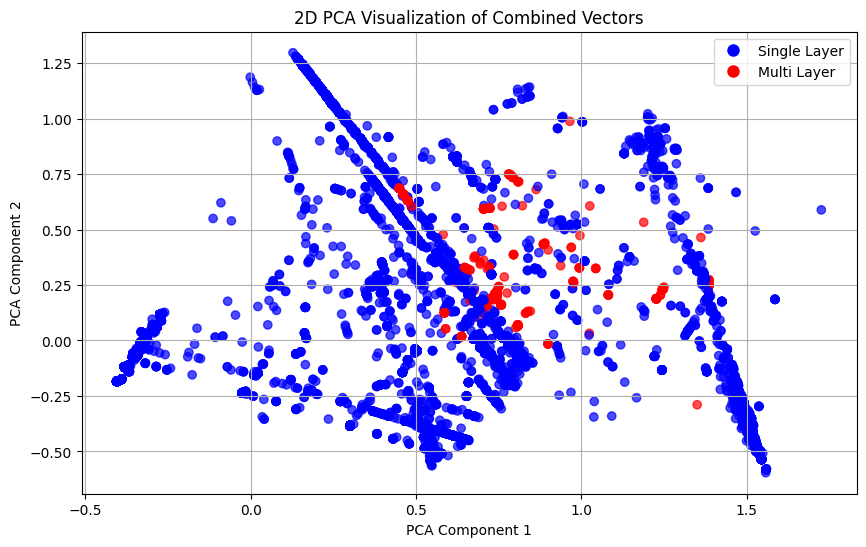

In [77]:
#### with colour coded perovskite type

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'combined_vectors' is the list of vectors and 'Layer Type' contains the labels
# First, ensure you have the combined vectors as NumPy arrays (if not already done)
vectors = np.stack(data['combined_vectors'].values)

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Create a color mapping for 'Layer Type' (single = blue, multi = red)
color_map = {'Single-layered Perovskite': 'blue', 'Multi-layered Perovskite': 'red'}

# Assign colors based on the 'Layer Type' column
colors = data['Layer Type'].map(color_map)

# Create a scatter plot to visualize the reduced vectors with color coding
plt.figure(figsize=(10, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=colors, alpha=0.7)

# Add labels and a title
plt.title('2D PCA Visualization of Combined Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Single Layer'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Multi Layer')]

plt.legend(handles=legend_elements)

# Show the plot
plt.grid(True)
plt.show()


2. Separate embeddings (RNNs)

### Feature Importance

1. Tree-based models

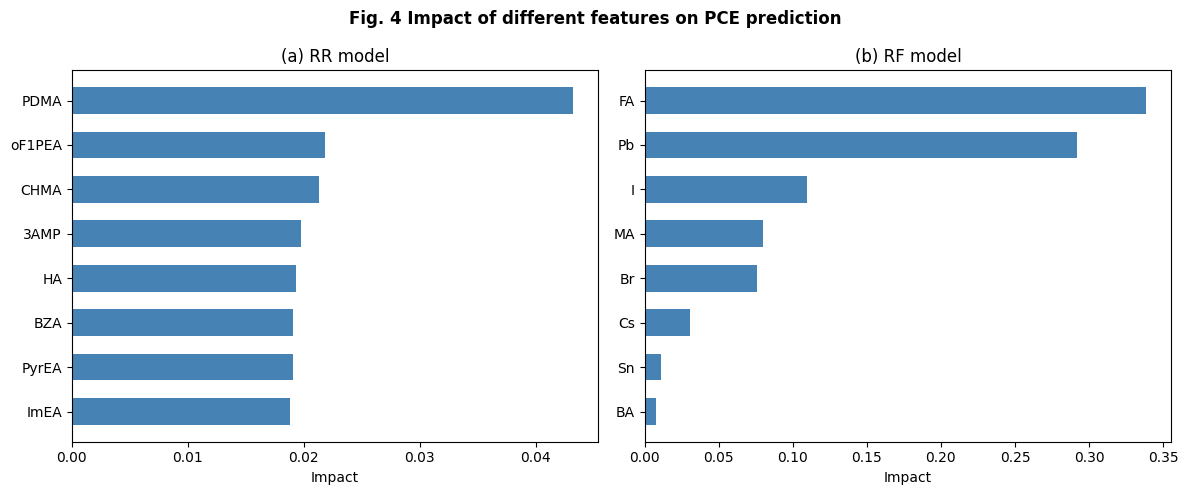

Ridge Regression Feature Importance:
    feature  importance
26     PDMA    0.043244
105  oF1PEA    0.021838
9      CHMA    0.021306
141    3AMP    0.019733
98       HA    0.019355
69      BZA    0.019081
53    PyrEA    0.019059
15     ImEA    0.018814

Random Forest Feature Importance:
    feature  importance
81       FA    0.338542
99       Pb    0.292218
85        I    0.109695
149      MA    0.080222
150      Br    0.075966
148      Cs    0.030370
131      Sn    0.010992
62       BA    0.007632


In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

#### test to predict efficiency (PCE)

# need to flatten lists/vector entries

# Drop rows in X where the target 'JV_default_PCE' is NaN
data_cleaned = data_cleaned.dropna(subset=['JV_default_PCE'])

# Prepare features and target
X = data_cleaned.drop(['JV_default_PCE', 'Cell_stack_sequence', 'Cell_architecture',
    'Substrate_stack_sequence', 'ETL_stack_sequence', 'HTL_stack_sequence', 'HTL_thickness_list', 
    'Backcontact_stack_sequence', 'Add_lay_front_stack_sequence', 'Add_lay_back_stack_sequence', 'Encapsulation_stack_sequence', 
    'Substrate_thickness', 'ETL_thickness', 'ETL_additives_compounds', 'ETL_additives_concentrations',
    'Perovskite_additives_compounds', 'Perovskite_additives_concentrations', 'Perovskite_thickness',
    'HTL_additives_compounds', 'HTL_additives_concentrations', 
    'Backcontact_additives_compounds', 'Backcontact_additives_concentrations',
    'Add_lay_front', 'Add_lay_front_function', 'Add_lay_front_thickness_list', 
    'Add_lay_front_additives_compounds', 'Add_lay_front_additives_concentrations',
    'Add_lay_back', 'Add_lay_back_function','Add_lay_back_thickness_list', 
    'Add_lay_back_additives_compounds', 'Add_lay_back_additives_concentrations',
    'Encapsulation', 'Layer Type', 'combined_ions', 'combined_coefficients', 'combined_sites'], axis=1)

y = data_cleaned['JV_default_PCE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression model
rr_model = Ridge()
rr_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance for Ridge Regression
rr_importance = np.abs(rr_model.coef_)
rr_importance = rr_importance / np.sum(rr_importance)
rr_feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rr_importance})
rr_feature_importance = rr_feature_importance.sort_values('importance', ascending=False).head(8)

# Get feature importance for Random Forest
rf_importance = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_importance})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False).head(8)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for RR model
ax1.barh(rr_feature_importance['feature'], rr_feature_importance['importance'], color='steelblue', height=0.6)
ax1.set_xlabel('Impact')
ax1.set_title('(a) RR model')
ax1.invert_yaxis()  # Invert y-axis to match the image

# Plot for RF model
ax2.barh(rf_feature_importance['feature'], rf_feature_importance['importance'], color='steelblue', height=0.6)
ax2.set_xlabel('Impact')
ax2.set_title('(b) RF model')
ax2.invert_yaxis()  # Invert y-axis to match the image

# Add overall title
fig.suptitle('Fig. 4 Impact of different features on PCE prediction', fontsize=12, fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.show()

# plt.savefig('PCE_feature_results.png', dpi=300, bbox_inches='tight')
# plt.close()
# print("Figure 4 with results has been generated and saved as 'figure_4_results.png'")

# Print feature importances
print("Ridge Regression Feature Importance:")
print(rr_feature_importance)
print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)


Permutation Feature Importance

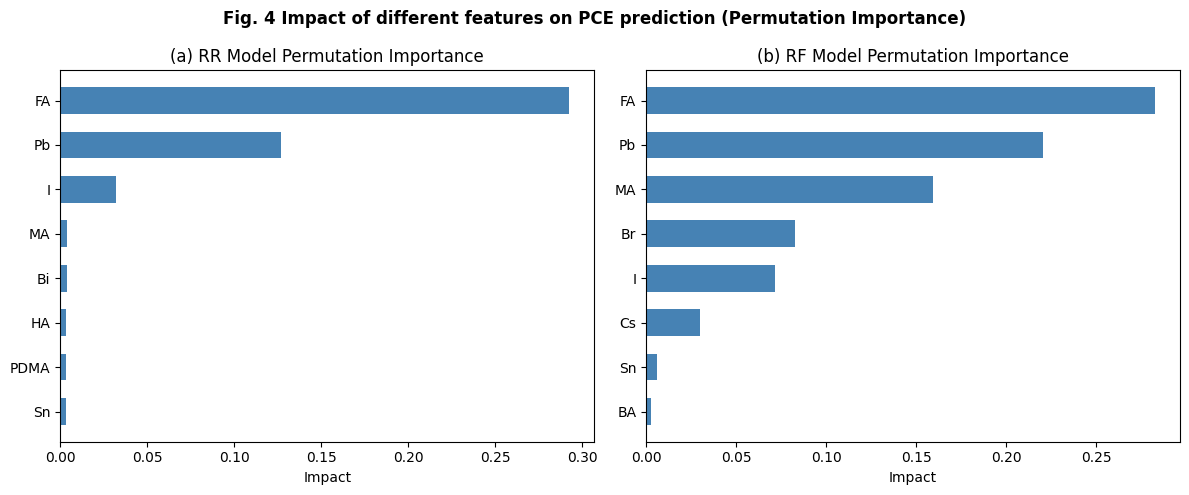

Ridge Regression Permutation Feature Importance:
    feature  importance
81       FA    0.292478
99       Pb    0.127157
85        I    0.031860
149      MA    0.003836
31       Bi    0.003695
98       HA    0.003178
26     PDMA    0.003121
131      Sn    0.003015

Random Forest Permutation Feature Importance:
    feature  importance
81       FA    0.282401
99       Pb    0.220218
149      MA    0.159570
150      Br    0.082727
85        I    0.071710
148      Cs    0.030063
131      Sn    0.006225
62       BA    0.003015


In [147]:
from sklearn.inspection import permutation_importance

# Drop rows in X where the target 'JV_default_PCE' is NaN
data_cleaned = data_cleaned.dropna(subset=['JV_default_PCE'])

# Prepare features and target
X = data_cleaned.drop(['JV_default_PCE', 'Cell_stack_sequence', 'Cell_architecture',
    'Substrate_stack_sequence', 'ETL_stack_sequence', 'HTL_stack_sequence', 'HTL_thickness_list', 
    'Backcontact_stack_sequence', 'Add_lay_front_stack_sequence', 'Add_lay_back_stack_sequence', 'Encapsulation_stack_sequence', 
    'Substrate_thickness', 'ETL_thickness', 'ETL_additives_compounds', 'ETL_additives_concentrations',
    'Perovskite_additives_compounds', 'Perovskite_additives_concentrations', 'Perovskite_thickness',
    'HTL_additives_compounds', 'HTL_additives_concentrations', 
    'Backcontact_additives_compounds', 'Backcontact_additives_concentrations',
    'Add_lay_front', 'Add_lay_front_function', 'Add_lay_front_thickness_list', 
    'Add_lay_front_additives_compounds', 'Add_lay_front_additives_concentrations',
    'Add_lay_back', 'Add_lay_back_function','Add_lay_back_thickness_list', 
    'Add_lay_back_additives_compounds', 'Add_lay_back_additives_concentrations',
    'Encapsulation', 'Layer Type', 'combined_ions', 'combined_coefficients', 'combined_sites'], axis=1)

y = data_cleaned['JV_default_PCE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression model
rr_model = Ridge()
rr_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# --- Permutation Feature Importance for Ridge Regression ---
rr_perm_importance = permutation_importance(rr_model, X_test, y_test, n_repeats=3, random_state=42, n_jobs=-1)

# Create DataFrame for RR permutation importance
rr_perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rr_perm_importance.importances_mean
})

# Sort by importance
rr_perm_importance_df = rr_perm_importance_df.sort_values('importance', ascending=False).head(8)

# --- Permutation Feature Importance for Random Forest ---
rf_perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=3, random_state=42, n_jobs=-1)

# Create DataFrame for RF permutation importance
rf_perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_perm_importance.importances_mean
})

# Sort by importance
rf_perm_importance_df = rf_perm_importance_df.sort_values('importance', ascending=False).head(8)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for RR model
ax1.barh(rr_perm_importance_df['feature'], rr_perm_importance_df['importance'], color='steelblue', height=0.6)
ax1.set_xlabel('Impact')
ax1.set_title('(a) RR Model Permutation Importance')
ax1.invert_yaxis()  # Invert y-axis to match the image

# Plot for RF model
ax2.barh(rf_perm_importance_df['feature'], rf_perm_importance_df['importance'], color='steelblue', height=0.6)
ax2.set_xlabel('Impact')
ax2.set_title('(b) RF Model Permutation Importance')
ax2.invert_yaxis()  # Invert y-axis to match the image

# Add overall title
fig.suptitle('Fig. 4 Impact of different features on PCE prediction (Permutation Importance)', fontsize=12, fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.show()

# Print feature importances
print("Ridge Regression Permutation Feature Importance:")
print(rr_perm_importance_df)
print("\nRandom Forest Permutation Feature Importance:")
print(rf_perm_importance_df)


Feature importance - element data only

In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

element_columns = ['NMA', 'BYA', 'DAP', 'Eu', 'HDA', 'Co', 'EU-pyP', 'TBA', 'DAT', 'CHMA', 'TMA', 'C6H13NH3', 
                        'Ba', 'Na', 'BI', 'ImEA', 'Ag', 'EPA', 'Br-PEA', 'THM', 'F-PEA', 'OdA', 'IA', 'Ada', 'BU', 'IM', 
                        'PDMA', 'NH4', 'PBA', 'Pt', 'Mg', 'BEA', 'PA', 'Bi', 'MIC3', '4AMP', 'CIEA', '3AMPY', 'Bn', 
                        'PPEA', 'C4H9N2H6', 'CA', '4AMPY', 'PF6', 'In', 'Anyl', 'PDA', 'Ni', '4ApyH', 'F3EA', 'TA', 'Fe', 
                        'PR', 'PyrEA', 'MTEA', 'Te', '3-PrNH32', 'Ti', 'AN', 'PEA', 'Li', 'Au', 'BA', 'TN', 'TEA', 'iso-BA', 
                        'ODA', 'BF4', 'PEI', 'BZA', 'OA', 'pF1PEA', 'BDA', 'F', 'n-C3H7NH3', 'Rb', 'Al', 'iPA', 'DMA', 'FEA', 
                        'Zn', 'DI','FA', 'Ca', 'HEA', 'mF1PEA', 'I', 'Sr', 'GABA', 'EDA', 'TFEA', 'Mn', 'F5PEA', '4FPEA', 'ThFA', 'Cr', 
                        'PMA', 'BzDA', 'ALA', 'C8H17NH3', 'HA', 'FPEA', 'BIM', 'Pb', 'Sb', 'MIC1', 'PN', 'oF1PEA', 'Hg', 'CPEA',
                        'pFPEA', 'Aa', 'EA', 'ThMA', 'Ace', 'GA', 'HdA', 'PyEA', 'CH33S', 'PGA', 'mFPEA', 'IEA', 'A43', 'DA', 'N-EtPy', 
                        'AVA', 'BdA', 'PPA', 'HTAB', 'Sm', 'f-PEA', '5-AVA', 'H-PEA', 'Sn', 'NEA', '5-AVAI', 'Nb', '6-ACA', 'Y', 
                        'FPEAI', 'Tb', 'Ge', 'NMABr', '3AMP', 'HAD', 'PTA', 'O', 'K', 'DPA', 'GU', 'Cs', 'MA', 'Br', 'MIC2', 
                        'S', 'BE', 'Cl-PEA', 'Cu', 'Cl', 'oFPEA', 'C6H4NH2', 'APMim', 'La', 'CH3ND3', 'C4H9NH3', 'SCN']


# # missing_columns = [col for col in element_columns if col not in data.columns]
# # if missing_columns:
# #     print(f"The following columns are missing: {missing_columns}")
# # else:
# #     print("All columns exist!")

# # Remove NaN values from y
# y = data['JV_default_PCE'].dropna()

# # Align X with the cleaned y by using the same index
# X = data[element_columns].loc[y.index]

# # Now X and y will have the same number of samples


# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scaling the features to ensure all coefficients have similar scale
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Train Random Forest model
# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train_scaled, y_train)

# # Evaluate the model
# train_score = rf_model.score(X_train_scaled, y_train)
# test_score = rf_model.score(X_test_scaled, y_test)

# print(f"Training R² Score: {train_score:.4f}")
# print(f"Testing R² Score: {test_score:.4f}")

# # Feature importances (to see which elements are most important)
# feature_importances = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': rf_model.feature_importances_
# })
# feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# print("\nFeature Importances:")
# print(feature_importances)

# correlations = data[element_columns + ['JV_default_PCE']].corr()
# print(correlations['JV_default_PCE'].sort_values(ascending=False))

# Assuming 'data' is your DataFrame and 'column_name' is the column you're interested in
column_name = 'I'  # Replace with your actual column name

# Filter out zero values
non_zero_values = data_cleaned[data_cleaned[column_name] != 0]

# Print the non-zero values
print(non_zero_values[column_name])



0        1.00
1        0.90
2        0.50
3        0.10
5        1.00
         ... 
42832    0.95
42833    0.95
42834    0.95
42835    0.95
42836    0.95
Name: I, Length: 40832, dtype: float64


### Training models
Predicting efficiency from the features with the largest impact on PCE (according to permutation feature importance)

Random Forest

In [ ]:
# ions only

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable
y = data_cleaned['JV_default_PCE']

# # Feature selection
# X = data_cleaned[['FA', 'Pb', 'I', 'MA', 'Bi', 'HA', 'PDMA', 'Sn', 'Br', 'Cs', 'BA']]  # Replace with relevant material features

element_columns = ['NMA', 'BYA', 'DAP', 'Eu', 'HDA', 'Co', 'EU-pyP', 'TBA', 'DAT', 'CHMA', 'TMA', 'C6H13NH3', 
                        'Ba', 'Na', 'BI', 'ImEA', 'Ag', 'EPA', 'Br-PEA', 'THM', 'F-PEA', 'OdA', 'IA', 'Ada', 'BU', 'IM', 
                        'PDMA', 'NH4', 'PBA', 'Pt', 'Mg', 'BEA', 'PA', 'Bi', 'MIC3', '4AMP', 'CIEA', '3AMPY', 'Bn', 
                        'PPEA', 'C4H9N2H6', 'CA', '4AMPY', 'PF6', 'In', 'Anyl', 'PDA', 'Ni', '4ApyH', 'F3EA', 'TA', 'Fe', 
                        'PR', 'PyrEA', 'MTEA', 'Te', '3-PrNH32', 'Ti', 'AN', 'PEA', 'Li', 'Au', 'BA', 'TN', 'TEA', 'iso-BA', 
                        'ODA', 'BF4', 'PEI', 'BZA', 'OA', 'pF1PEA', 'BDA', 'F', 'n-C3H7NH3', 'Rb',# 'AI',
                        'iPA', 'DMA', 'FEA', 
                        'Zn', 'DI','FA', 'Ca', 'HEA', 'mF1PEA', 'I', 'Sr', 'GABA', 'EDA', 'TFEA', 'Mn', 'F5PEA', '4FPEA', 'ThFA', #'Cr', 
                        'PMA', 'BzDA', 'ALA', 'C8H17NH3', 'HA', 'FPEA', 'BIM', 'Pb', 'Sb', 'MIC1', 'PN', 'oF1PEA', 'Hg', 'CPEA',
                        'pFPEA', 'Aa', 'EA', 'ThMA', 'Ace', 'GA', 'HdA', 'PyEA', 'CH33S', 'PGA', 'mFPEA', 'IEA', 'A43', 'DA', 'N-EtPy', 
                        'AVA', 'BdA', 'PPA', 'HTAB', 'Sm', 'f-PEA', '5-AVA', 'H-PEA', 'Sn', 'NEA', '5-AVAI', 'Nb', '6-ACA', 'Y', 
                        'FPEAI', 'Tb', 'Ge', 'NMABr', '3AMP', 'HAD', 'PTA', 'O', 'K', 'DPA', 'GU', 'Cs', 'MA', 'Br', 'MIC2', 
                        'S', 'BE', 'Cl-PEA', 'Cu', 'Cl', 'oFPEA', 'C6H4NH2', 'APMim', 'La', 'CH3ND3', 'C4H9NH3', 'SCN']

X = data_cleaned[element_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

initial_rf = RandomForestRegressor(random_state=42)
initial_rf.fit(X_train, y_train)

y_pred = initial_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

# importances = initial_rf
#.feature_importances_
# feature_names = X.columns

# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances, y=feature_names)
# plt.title('Feature Importances')
# plt.show()

print(y_pred)

#### optimise hyperparameters  

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and refit model
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

#### re-evaluate

y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned Mean Squared Error: {mse_best}")
print(f"Tuned R^2 Score: {r2_best}")

# save model
# import joblib
# joblib.dump(best_rf, 'random_forest_efficiency_model.pkl')

# load model when needed
# rf_model = joblib.load('random_forest_efficiency_model.pkl')

# Compare before and after optimization
y_pred_before = initial_rf.predict(X_test)  # Predictions before tuning
y_pred_after = best_rf.predict(X_test)     # Predictions after tuning

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test - y_pred_before, color='blue', label='Before')
plt.scatter(y_test, y_test - y_pred_after, color='red', label='After')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals: Before vs. After Hyperparameter Tuning')
plt.legend()



Neural Networks

In [ ]:
# ions only 
import tensorflow
from sklearn.preprocessing import StandardScaler

# Standardize the data (this step is important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential()

# Add layers: input layer (implicitly defined by input_shape), one hidden layer, and output layer
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Hidden layer
model.add(Dense(32, activation='relu'))  # Another hidden layer
model.add(Dense(1))  # Output layer for regression (no activation for regression)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# to prevent overfitting

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])


# evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")



Epoch 1/50


c:\Users\c\miniconda3\envs\test-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 59.7677 - mae: 6.0061 - val_loss: 23.1381 - val_mae: 3.7253
Epoch 2/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.4937 - mae: 3.6996 - val_loss: 22.2636 - val_mae: 3.6641
Epoch 3/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.9801 - mae: 3.6600 - val_loss: 22.1302 - val_mae: 3.6371
Epoch 4/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.7515 - mae: 3.6326 - val_loss: 22.0272 - val_mae: 3.6458
Epoch 5/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.4413 - mae: 3.6115 - val_loss: 21.7706 - val_mae: 3.6987
Epoch 6/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.4839 - mae: 3.6152 - val_loss: 22.3320 - val_mae: 3.6316
Epoch 7/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.4779 - mae: 3.6202 - val_loss: 21.4962 - val_mae: 3.5890
Epoch 8/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.0366 - mae: 3.5687 - val_loss: 21.3246 - val_mae: 3.6638
Epoch 9/50
1049/1049 ━━━━━━━━━━━━━━

Comparison of RF to NN predictions

In [165]:
from sklearn.metrics import mean_squared_error, r2_score

# # Random Forest predictions (assumed you've already made them)
# y_pred_rf = rf_model.predict(X_test)  # Assuming rf_model is your trained random forest model

# # Compute MSE and R² for Random Forest
# mse_best = mean_squared_error(y_test, y_pred_rf)
# r2_best = r2_score(y_test, y_pred_rf)

# # Compute MSE and R² for Neural Network
# mse_nn = mean_squared_error(y_test, y_pred_nn)
# r2_nn = r2_score(y_test, y_pred_nn)

# print(f"Random Forest MSE: {mse_best}, R²: {r2_best}")
# print(f"Neural Network MSE: {mse_nn}, R²: {r2_nn}")

# normalise and compare rf to nn

relative_mae = (mae / np.mean(y_test)) * 100  # MAE as percentage of the mean target
relative_mse = (mse / np.mean(y_test)) * 100  # MSE as percentage of the mean target

print('Relative mae as a percentage of mean target (NN):', relative_mae)
print('Relative mse as a percentage of mean target (RF):', relative_mse)

# import matplotlib.pyplot as plt

# # Plot actual vs. predicted values for RF
# plt.scatter(y_test, rf_model_predictions)
# plt.xlabel('Actual Efficiency')
# plt.ylabel('RF Model Predictions')
# plt.title('RF Model: Actual vs Predicted')
# plt.show()

# # Plot actual vs. predicted values for NN
# plt.scatter(y_test, nn_model_predictions)
# plt.xlabel('Actual Efficiency')
# plt.ylabel('NN Model Predictions')
# plt.title('NN Model: Actual vs Predicted')
# plt.show()



Relative mae as a percentage of mean target (NN): 29.72713635700866
Relative mse as a percentage of mean target (RF): 157.969379513661
